In [1]:
import bioread
import numpy as np
import pandas as pd
import heartpy as hp
import neurokit2 as nk
import os 

df_list = []
channels_to_extract = ['ECG - ECG100C', 'C5 - Expression' ]
directory_path = r'C:\Users\User\Desktop\NPU_FILES'

for filename in os.listdir(directory_path):
    if filename.endswith(".acq"):
        file_path= os.path.join(directory_path, filename)
        acq_file = bioread.read_file(file_path)
        data = {}
        for channel_name in channels_to_extract:
            channel = acq_file.named_channels[channel_name]
            data[channel_name] = channel.data

        df = pd.DataFrame(data)
        df_list.append(df)
for i, df in enumerate(df_list):
    print(f"DataFrame for file {i}:\n", df)


DataFrame for file 0:
          ECG - ECG100C  C5 - Expression
0             0.018158              0.0
1             0.015869              0.0
2             0.013733              0.0
3             0.011292              0.0
4             0.008698              0.0
...                ...              ...
4554011      -0.063019              0.0
4554012      -0.062408              0.0
4554013      -0.062408              0.0
4554014      -0.062256              0.0
4554015      -0.062256              0.0

[4554016 rows x 2 columns]
DataFrame for file 1:
          ECG - ECG100C  C5 - Expression
0             0.001068              0.0
1             0.000763              0.0
2             0.000916              0.0
3             0.000763              0.0
4             0.000916              0.0
...                ...              ...
8082244       0.280304              0.0
8082245       0.281372              0.0
8082246       0.281982              0.0
8082247       0.282745              0.0
808224

In [2]:
for df in df_list:
    df = df.dropna()
    df = df.reset_index(drop=True)


In [3]:

for i, df in enumerate(df_list):
    non_zero_indices = df.index[df['C5 - Expression'] != 0]
    index_rows_to_change = []
    for j in range(len(non_zero_indices) - 1):
        if non_zero_indices[j + 1] == non_zero_indices[j] + 1:
            index_rows_to_change.append(non_zero_indices[j])
    modified_df = df.copy()  # Create a copy of the DataFrame
    for index in index_rows_to_change:
        modified_df.loc[index, 'C5 - Expression'] = 0
    # Update the DataFrame in df_list with the modified one
    df_list[i] = modified_df

In [11]:
baseline_row_numbers = []  

for df in df_list:
    baseline_row = df.index[df['C5 - Expression'] == 99].tolist()
    if len(baseline_row) > 0:
        baseline_row_numbers.append(baseline_row[0])
    

for i, baseline_rows in enumerate(baseline_row_numbers):
    print(f"Baseline rows for DataFrame {i}: {baseline_rows}\n")

Baseline rows for DataFrame 0: 2002573

Baseline rows for DataFrame 1: 2511643

Baseline rows for DataFrame 2: 6121595

Baseline rows for DataFrame 3: 643262

Baseline rows for DataFrame 4: 151909


In [12]:

baseline_minutes = []

for df, baseline_row in zip(df_list, baseline_row_numbers):
    calc_minute = df.iloc[baseline_row:baseline_row + (2000 * 60)]
    calc_minute = calc_minute[['ECG - ECG100C']]
    baseline_minutes.append(calc_minute)

# Print the extended DataFrames
for i, extended_df in enumerate(baseline_minutes):
    print(f"Extended DataFrame {i}:\n{baseline_minutes}\n")

Extended DataFrame 0:
[         ECG - ECG100C
2002573      -0.141144
2002574      -0.138702
2002575      -0.137329
2002576      -0.135651
2002577      -0.134735
...                ...
2122568      -0.025024
2122569      -0.024261
2122570      -0.024719
2122571      -0.024567
2122572      -0.024719

[120000 rows x 1 columns],          ECG - ECG100C
2511643       0.612488
2511644       0.577087
2511645       0.541382
2511646       0.503998
2511647       0.466461
...                ...
2631638      -0.062561
2631639      -0.061646
2631640      -0.060883
2631641      -0.060272
2631642      -0.059814

[120000 rows x 1 columns], Empty DataFrame
Columns: [ECG - ECG100C]
Index: [],         ECG - ECG100C
643262      -0.037079
643263      -0.037231
643264      -0.037079
643265      -0.037384
643266      -0.037537
...               ...
763257      -0.064087
763258      -0.064087
763259      -0.063782
763260      -0.063477
763261      -0.063629

[120000 rows x 1 columns],         ECG - ECG100C
151

In [14]:
all_baseline_arrays = []
for df in baseline_minutes:
    baseline_minute_array = df['ECG - ECG100C'].values.flatten()
    if len(baseline_minute_array) > 0:
        all_baseline_arrays.append(baseline_minute_array)
    
for array in all_baseline_arrays:
        print(len(array))


120000
120000
120000
120000


In [19]:
mean_heart_rates = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    heart_rate = signals["ECG_Rate"]
    heart_rate_mean = heart_rate.mean()
    heart_rate_std = heart_rate.std()
    mean_heart_rates.append(heart_rate_mean)
    overall_std_mean_heart_rate = np.std(mean_heart_rates)


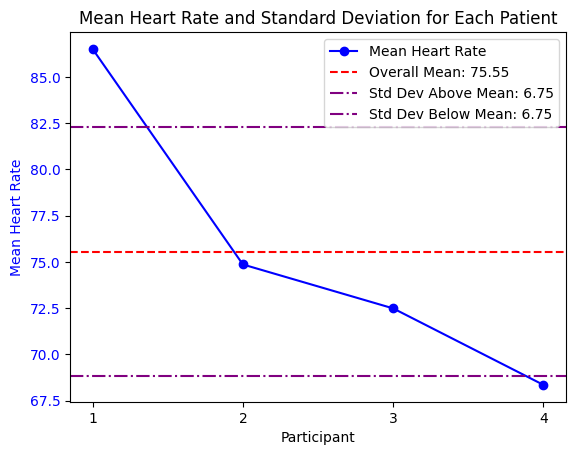

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the overall mean heart rate
overall_mean_heart_rate = sum(mean_heart_rates) / len(mean_heart_rates)

# Calculate the overall standard deviation of the mean heart rates
overall_std_mean_heart_rate = np.std(mean_heart_rates)

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot individual mean heart rates
ax1.plot(range(1, len(mean_heart_rates) + 1), mean_heart_rates, color='blue', marker='o', linestyle='-', label='Mean Heart Rate')

# Add a horizontal line for the overall mean heart rate
ax1.axhline(y=overall_mean_heart_rate, color='red', linestyle='--', label=f'Overall Mean: {overall_mean_heart_rate:.2f}')

# Add a horizontal line for the overall standard deviation of the mean heart rates
ax1.axhline(y=overall_mean_heart_rate + overall_std_mean_heart_rate, color='purple', linestyle='-.', label=f'Std Dev Above Mean: {overall_std_mean_heart_rate:.2f}')
ax1.axhline(y=overall_mean_heart_rate - overall_std_mean_heart_rate, color='purple', linestyle='-.', label=f'Std Dev Below Mean: {overall_std_mean_heart_rate:.2f}')

# Set labels and title for the first y-axis
ax1.set_xlabel('Participant')
ax1.set_ylabel('Mean Heart Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Mean Heart Rate and Standard Deviation for Each Patient')
ax1.set_xticks(range(1, len(mean_heart_rates) + 1))  # Set x-axis ticks to integers

# Add legends
ax1.legend(loc='upper right')

# Show plot
plt.show()

In [21]:
# HRV mean
mean_hrv = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    hrv_time = nk.hrv_time(signals, sampling_rate=2000)
    hrv_mean = hrv_time['HRV_MeanNN']
    mean_hrv.append(hrv_mean)
    

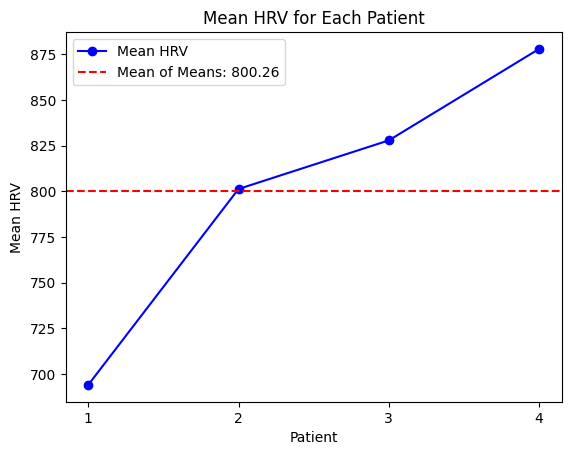

In [22]:
overall_mean_hrv = np.mean(mean_hrv)

# Create a line plot for individual mean HRV values
plt.plot(range(1, len(mean_hrv) + 1), mean_hrv, marker='o', linestyle='-', color='blue', label='Mean HRV')

# Add a horizontal line for the mean of means
plt.axhline(y=overall_mean_hrv, color='red', linestyle='--', label=f'Mean of Means: {overall_mean_hrv:.2f}')

# Add labels and title
plt.xlabel('Patient')
plt.ylabel('Mean HRV')
plt.title('Mean HRV for Each Patient')
plt.xticks(range(1, len(mean_hrv) + 1))  # Set x-axis ticks to integers

# Add legend
plt.legend()

# Show plot
plt.show()

In [23]:
# frequency-domain HRV features
lf_powers = []
hf_powers = []
lf_hf_ratios = []
for array in all_baseline_arrays:
    signals, info = nk.ecg_process(array, 2000)
    hrv_freq = nk.hrv_frequency(signals, sampling_rate=2000)

    lf_power = hrv_freq['HRV_LF']
    lf_powers.append(lf_power)
    hf_power = hrv_freq['HRV_HF']
    hf_powers.append(hf_power)
    lf_hf_ratio = hrv_freq['HRV_LFHF']
    lf_hf_ratios.append(lf_hf_ratio)


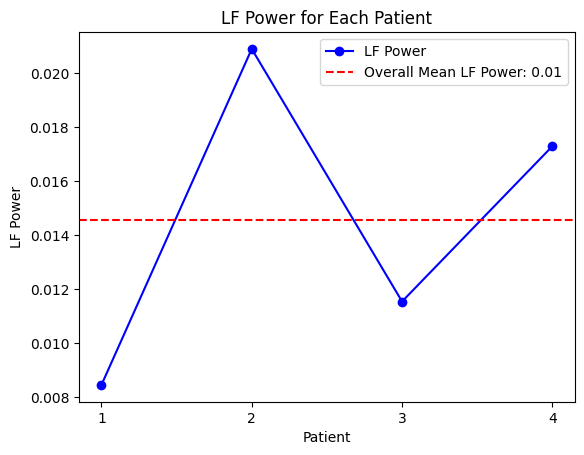

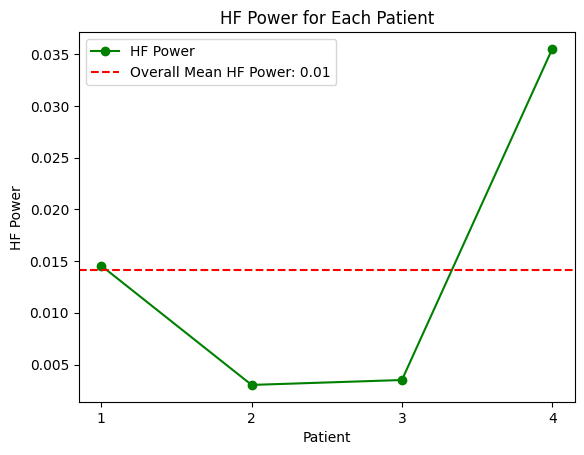

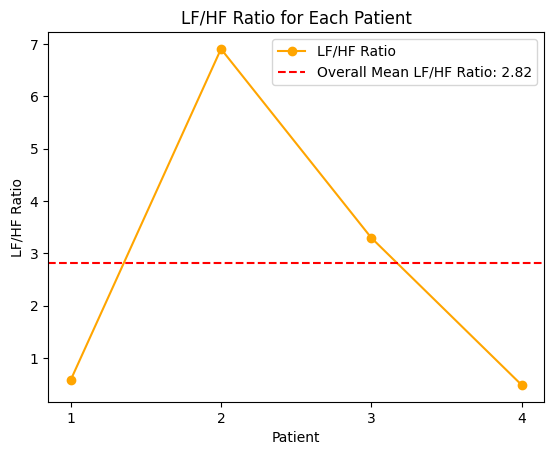

In [24]:
# Calculate overall means for each feature
overall_mean_lf_power = np.mean(lf_powers)
overall_mean_hf_power = np.mean(hf_powers)
overall_mean_lf_hf_ratio = np.mean(lf_hf_ratios)

# Plotting LF Powers
plt.plot(range(1, len(lf_powers) + 1), lf_powers, marker='o', linestyle='-', color='blue', label='LF Power')
plt.axhline(y=overall_mean_lf_power, color='red', linestyle='--', label=f'Overall Mean LF Power: {overall_mean_lf_power:.2f}')
plt.xlabel('Patient')
plt.ylabel('LF Power')
plt.title('LF Power for Each Patient')
plt.xticks(range(1, len(lf_powers) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

# Plotting HF Powers
plt.plot(range(1, len(hf_powers) + 1), hf_powers, marker='o', linestyle='-', color='green', label='HF Power')
plt.axhline(y=overall_mean_hf_power, color='red', linestyle='--', label=f'Overall Mean HF Power: {overall_mean_hf_power:.2f}')
plt.xlabel('Patient')
plt.ylabel('HF Power')
plt.title('HF Power for Each Patient')
plt.xticks(range(1, len(hf_powers) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

# Plotting LF/HF Ratios
plt.plot(range(1, len(lf_hf_ratios) + 1), lf_hf_ratios, marker='o', linestyle='-', color='orange', label='LF/HF Ratio')
plt.axhline(y=overall_mean_lf_hf_ratio, color='red', linestyle='--', label=f'Overall Mean LF/HF Ratio: {overall_mean_lf_hf_ratio:.2f}')
plt.xlabel('Patient')
plt.ylabel('LF/HF Ratio')
plt.title('LF/HF Ratio for Each Patient')
plt.xticks(range(1, len(lf_hf_ratios) + 1))  # Set x-axis ticks to integers
plt.legend()
plt.show()

In [58]:
ecg_data =  {
    "n_cue": [],
    "n_no_cue": [],
    "p_cue": [],
    "p_no_cue": [],
    "u_cue": [],
    "u_no_cue": []
}
for index, row in df.iterrows():
    value = row['C5 - Expression']
    ecg_value = row['ECG - ECG100C']
    
    
    if value == 020.0:
        ecg_data["n_cue"].append(ecg_value)
    if value == 030.0:
        ecg_data["n_no_cue"].append(ecg_value)
    if value == 120.0:
        ecg_data["p_cue"].append(ecg_value)
    if value == 130.0:
        ecg_data["p_no_cue"].append(ecg_value)
    if value == 220.0:
        ecg_data["u_cue"].append(ecg_value)
    if value == 230.0:
        ecg_data["u_no_cue"].append(ecg_value)
        
max_length = max(len(ecg_data[key]) for key in ecg_data)
for key in ecg_data:
    while len(ecg_data[key]) < max_length:
        ecg_data[key].append(None)
df_ecg = pd.DataFrame(ecg_data)
print(df_ecg)


    
         


KeyError: 'C5 - Expression'

In [ ]:


## trying with neurokit   
ecg_sampling_rate = 2000
heart_rate_data = {}
for column in df_ecg.columns:
    signals = nk.ecg_process(df_ecg[column], ecg_sampling_rate)
    heart_rate = nk.ecg_rate(signals)
    heart_rate_data[column] = heart_rate
print("Heart Rates:")
for column, heart_rate in heart_rate_data.items():
    print(f"{column}: {heart_rate.mean()} bpm")

heart_rate_df = pd.DataFrame(heart_rate_data)

mean_heart_rate_per_column = heart_rate_df.mean(axis=0)

print("Mean Heart Rate per column:")
print(mean_heart_rate_per_column)
    
    







    